In [ ]:
# Install the latest version of qonscious
%pip install -U qonscious

# You can alternatively install the development version in a venv and use that
# with your notebook.

# Qonscious as a benchmarking orchestrator

You can use Qonscious to compare backends by a given figure of merit. This examples show how you can do that (one simple approach)

Let's go step by step. We will explore:

1. Create a list of all backends (adapters) we want to compare.
2. Configure a CHSH compliance check that will allways pass (we want it to pass even if the value is bad because we just want to report results)
3. Create a function that stores in a list the result of evaluating the figure of merit.
4. Iterate on all backends, running the figure of merit check
5. Plot results 

Notice that for this usage scenario we do not need to prepare any circuits. If figures of merit need to run a circuit, they take care of it.

In [23]:
# let's create a list of all the backend adapters we want to benchmark
backend_adapters =[]

# decide which of the following cells to run to populate the list

**IBM (real)**

Run the following cell if you want to include IBM's real backends in the benchmark. 
You need to provide an access token and you must have available compute credits.
It will include all backends available to that token.

In [14]:
import os

from qonscious.adapters import IBMSamplerAdapter

# Get adaptors on all backends available to your account, with at least 8 qubits
ibm_token = os.getenv("IBM_QUANTUM_TOKEN")
backend_adapters.extend(IBMSamplerAdapter.all_available_backends(ibm_token, min_num_qubits=8))

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-10-22 16:21:03,049: Default instance not set. Searching all available instances.


**IONQ (simulated)** 

Run the following cell if you want to include IONQ's (Aria and Harmony) simulated backends in the benchmark. 
You need to provide an apikey.
You do not need compute credits.

In [ ]:
import os

from qonscious.adapters import IonQBackendAdapter

# Get adapters for IonQ simulated backends
api_key = os.getenv("IONQ_API_KEY")
backend_adapters.append(IonQBackendAdapter.harmony_simulator(api_key))
backend_adapters.append(IonQBackendAdapter.aria_simulator(api_key))


**IBM (simulated)** 

Run the following cell if you want to include IBM's simulated backends in the benchmark. 
You need to provide an token.
You do not need compute credits.

In [ ]:
from qiskit_ibm_runtime.fake_provider import (
    FakeAlgiers,
    FakeAuckland,
    FakeBrisbane,
    FakeCusco,
    FakeFez,
    FakeGeneva,
    FakeGuadalupeV2,
    FakeHanoiV2,
    FakeKawasaki,
    FakeKolkataV2,
    FakeKyiv,
    FakeKyoto,
    FakeMarrakesh,
    FakeMelbourneV2,
    FakeMontrealV2,
    FakeMumbaiV2,
    FakeOsaka,
    FakePeekskill,
    FakePrague,
    FakeQuebec,
    FakeSherbrooke,
    FakeSydneyV2,
    FakeTorino,
    FakeTorontoV2,
    FakeWashingtonV2,
)

from qonscious.adapters import IBMSamplerAdapter

# Get adaptors for a selection of IBM simulated backends that we know have at least 8 qubits

fake_backends_classes = [FakeAlgiers, FakeAuckland, FakeBrisbane, FakeCusco, FakeFez,
                 FakeGeneva, FakeGuadalupeV2, FakeHanoiV2, FakeKawasaki, FakeKolkataV2, FakeKyiv,
                 FakeKyoto, FakeMarrakesh, FakeMelbourneV2, FakeMontrealV2, FakeMumbaiV2, FakeOsaka,
                 FakePeekskill, FakePrague, FakeQuebec, FakeSherbrooke, FakeSydneyV2, FakeTorino,
                 FakeTorontoV2, FakeWashingtonV2]

backend_adapters.extend(IBMSamplerAdapter(backend_class()) for backend_class
                        in fake_backends_classes)


Let's create merit compliance check with a PackedCHSHTest as the figure of merit

In [17]:
from qonscious.checks import MeritComplianceCheck
from qonscious.foms import PackedCHSHTest


# If we set CHSH score to be over 2, we are certain all checks will pass
def chsh_score_over(threshold: float):
    return lambda r: r["properties"]["score"] > threshold

check_chsh_is_ok = MeritComplianceCheck(
    figure_of_merit=PackedCHSHTest(),
    decision_function=chsh_score_over(2),
)

Let's prepare our pass function (that records the result of the evaluation of the figure of merit) and our fail function that does nothing (out check will never fail)

In [18]:
from qonscious.adapters import BackendAdapter

results = []

# This is the callback function that will run if the CHSH checks passes (in our case, always).
# It appends the result of evaluating the FOM on the backend.
def on_pass(backend_adapter : BackendAdapter, figureOfMeritResults):
    info = {
        "score" : figureOfMeritResults[0]["properties"]["score"],
        "backend": backend_adapter.name,
        "n_qubits": backend_adapter.n_qubits,
    }
    results.append(info)
    return None

def on_fail(backend_adapter : BackendAdapter, figureOfMeritResults):
    return None

Let's run our run_conditionally workflow on all backends

In [25]:
from qonscious import run_conditionally
from qonscious.actions import QonsciousCallable

try:
    for adapter in backend_adapters:
        run_conditionally(
            backend_adapter=adapter,
            checks= [check_chsh_is_ok],
            on_pass=QonsciousCallable(on_pass),
            on_fail=QonsciousCallable(on_fail)
        )
except Exception as error:
    print(f"An error ocurred while benchmarking: {error} with: {adapter.backend.name}")

Lets look at the results

In [28]:
results

[{'score': 2.677734375, 'backend': 'ibm_brisbane', 'n_qubits': 127},
 {'score': 2.697265625, 'backend': 'ibm_torino', 'n_qubits': 133},
 {'score': 2.7265625, 'backend': 'fake_algiers', 'n_qubits': 27},
 {'score': 2.693359375, 'backend': 'fake_auckland', 'n_qubits': 27},
 {'score': 2.619140625, 'backend': 'fake_brisbane', 'n_qubits': 127},
 {'score': 2.587890625, 'backend': 'fake_cusco', 'n_qubits': 127},
 {'score': 2.685546875, 'backend': 'fake_fez', 'n_qubits': 156},
 {'score': 2.546875, 'backend': 'fake_geneva', 'n_qubits': 27},
 {'score': 2.625, 'backend': 'fake_guadalupe', 'n_qubits': 16},
 {'score': 2.763671875, 'backend': 'fake_hanoi', 'n_qubits': 27},
 {'score': 2.677734375, 'backend': 'fake_kawasaki', 'n_qubits': 127},
 {'score': 2.697265625, 'backend': 'fake_kolkata', 'n_qubits': 27},
 {'score': 2.591796875, 'backend': 'fake_kyiv', 'n_qubits': 127},
 {'score': 2.76171875, 'backend': 'fake_marrakesh', 'n_qubits': 156},
 {'score': 2.3671875, 'backend': 'fake_melbourne', 'n_qubit

# Analyze results

Let's plot horizontal bars to compare scores, using a different color for the fake backends.

Let's figure out how the "real" quantum computers compare to the fake ones.

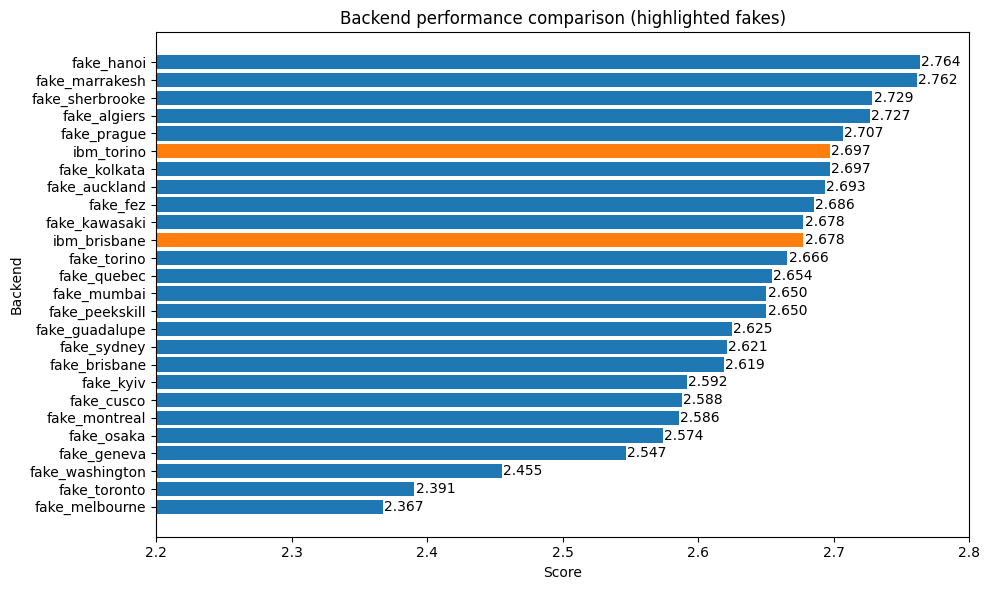

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(results)

df_sorted = df.sort_values('score', ascending=False)

colors = ['tab:blue' if name.startswith('fake') else 'tab:orange'
          for name in df_sorted['backend']]

plt.figure(figsize=(10, 6))
bars = plt.barh(df_sorted['backend'], df_sorted['score'], color=colors)
plt.xlabel('Score')
plt.ylabel('Backend')
plt.title('Backend performance comparison (highlighted fakes)')
plt.xlim(2.2, 2.8)
plt.gca().invert_yaxis()

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001,
             bar.get_y() + bar.get_height()/2,
             f'{width:.3f}',
             va='center')

plt.tight_layout()
plt.show()

# More qubits equals better score?

Let's see if we find a correlation between the score and the number of qubits of the computer?

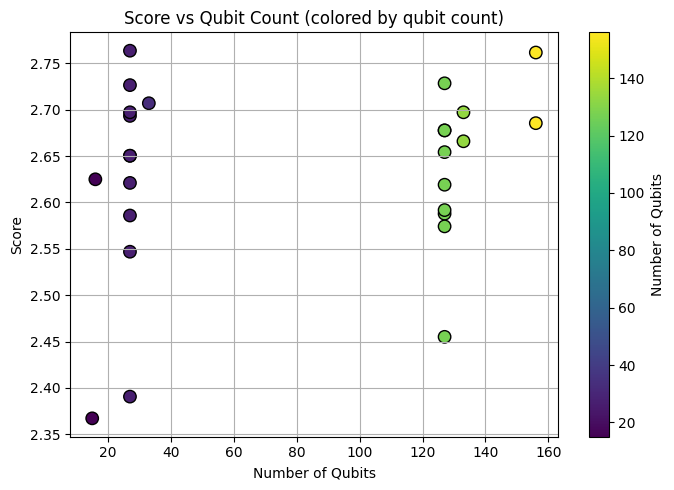

In [33]:
plt.figure(figsize=(7, 5))

# Use scatter with color mapped to 'n_qubits'
sc = plt.scatter(
    df['n_qubits'],
    df['score'],
    c=df['n_qubits'],          # color encoding
    cmap='viridis',            # or 'plasma', 'coolwarm', etc.
    s=80,                      # marker size
    edgecolor='k',             # outline for visibility
)

plt.xlabel('Number of Qubits')
plt.ylabel('Score')
plt.title('Score vs Qubit Count (colored by qubit count)')
plt.grid(True)

cbar = plt.colorbar(sc)
cbar.set_label('Number of Qubits')

plt.tight_layout()
plt.show()

# Qubit count or architecture?

There is a strong correlation between the number of qubits and the score obtained, but is it just that, or is there something about the architecture of the quantum computer that influences the score?

In [ ]:
# Let's (manually) populate a mapping from processors to their chip/architecture based on
# what is available on-line and see if it results in a better correlation

backend_to_arch = {
  "ibm_brisbane": "Eagle",
  "ibm_torino": "Heron r1",
  "fake_algiers": "Falcon",
  "fake_auckland": "Falcon",
  "fake_brisbane": "Eagle",
  "fake_cusco": "Eagle",
  "fake_fez": "Heron r2",
  "fake_geneva": "Falcon",
  "fake_guadalupe": "Falcon",
  "fake_hanoi": "Falcon",
  "fake_kawasaki": "Eagle",
  "fake_kolkata": "Falcon",
  "fake_kyiv": "Eagle",
  "fake_marrakesh": "Heron r2",
  "fake_melbourne": "Unknown",
  "fake_montreal": "Falcon",
  "fake_mumbai": "Falcon",
  "fake_osaka": "Eagle",
  "fake_peekskill": "Falcon",
  "fake_prague": "Unknown",
  "fake_quebec": "Eagle",
  "fake_sherbrooke": "Eagle",
  "fake_sydney": "Falcon",
  "fake_torino": "Heron r1",
  "fake_toronto": "Falcon",
  "fake_washington": "Eagle"
}

results_with_arch = [
    {**entry, "architecture": backend_to_arch.get(entry["backend"], "Unknown")}
    for entry in results
]

<Figure size 1000x600 with 0 Axes>

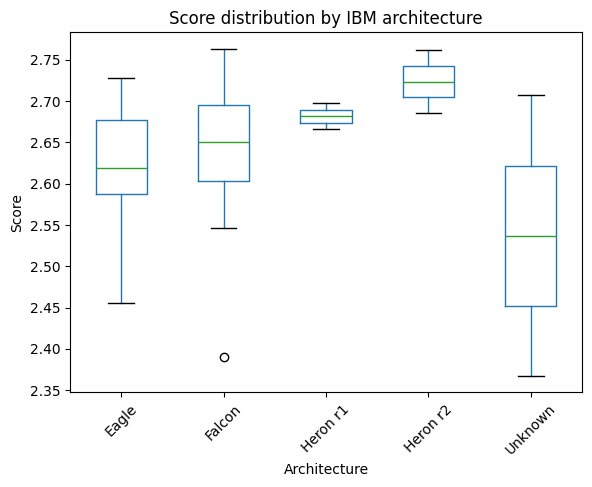

In [38]:
df = pd.DataFrame(results_with_arch)

plt.figure(figsize=(10,6))
df.boxplot(column="score", by="architecture", grid=False)
plt.title("Score distribution by IBM architecture")
plt.suptitle("")
plt.xlabel("Architecture")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()

# Disclaimer

This notebook aims to serve as an example of the type of works that Qonscious support. 

These are some of its limitatios, that must be taken into account to turn this example into a real experiment

* It considers the performance of simulated computers (e.g., fake backends by IBM) as been truthfull to the real device
* It run only once (1024 shots) on real backends
* PackedCHSHTest is only an example of the types of Figures of merit that can be created and used in QOnscious. It is not a strong indicator of quantum computer performance
* The mapping from computer name to chip/architecture was done manually on information available on-line. 